In [1]:
from google.colab import drive
import sys


drive.mount('/content/drive', force_remount=True)

sys.path.append('/content/drive/MyDrive/dnn_model_optimization')

Mounted at /content/drive


In [2]:
!pip install -q torchmetrics torchinfo

In [3]:
from utils.data import load_data

((train_imgs, train_abits), train_labels), ((val_imgs, val_abits), val_labels), alphabet = load_data('/content/drive/MyDrive/dnn_model_optimization/data', split=True)

In [4]:
from torch.utils.data import DataLoader
from utils.data import OCRDataset


train_dataset = OCRDataset(train_imgs, train_abits, train_labels)
val_dataset = OCRDataset(val_imgs, val_abits, val_labels)

train_loader = DataLoader(train_dataset, batch_size=128)
val_loader = DataLoader(val_dataset, batch_size=128)

In [5]:
from utils.torch_model import CRNN
from utils.data import decode_texts
from utils.torch_helpers import init_weights
from torchinfo import summary
import torch

model = CRNN(len(alphabet))
model.apply(init_weights)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

summary(model, input_size=[(128, 1, 32, 400), (128, 50, 2)])

Layer (type:depth-idx)                   Output Shape              Param #
CRNN                                     [128, 50, 46]             --
├─Sequential: 1-1                        [128, 256, 1, 50]         --
│    └─ConvBlock: 2-1                    [128, 32, 16, 200]        --
│    │    └─Sequential: 3-1              [128, 32, 16, 200]        384
│    └─ConvBlock: 2-2                    [128, 64, 8, 200]         --
│    │    └─Sequential: 3-2              [128, 64, 8, 200]         18,624
│    └─ConvBlock: 2-3                    [128, 64, 4, 100]         --
│    │    └─Sequential: 3-3              [128, 64, 4, 100]         37,056
│    └─ConvBlock: 2-4                    [128, 128, 2, 50]         --
│    │    └─Sequential: 3-4              [128, 128, 2, 50]         74,112
│    └─ConvBlock: 2-5                    [128, 256, 1, 50]         --
│    │    └─Sequential: 3-5              [128, 256, 1, 50]         295,680
├─LSTM: 1-2                              [128, 50, 256]            

In [6]:
from utils.torch_helpers import train_model

best_state, history = train_model(model, alphabet, 1000, train_loader, val_loader=val_loader, device=device)
model.load_state_dict(best_state)

Epoch 0, 103/103, loss: 40.189577, cer: 0.999179, val_loss: 39.845156, val_cer: 0.968519
Epoch 1, 103/103, loss: 18.749931, cer: 0.579965, val_loss: 8.877112, val_cer: 0.235545
Epoch 2, 103/103, loss: 2.084497, cer: 0.071571, val_loss: 5.016007, val_cer: 0.165244
Epoch 3, 103/103, loss: 0.799903, cer: 0.047341, val_loss: 4.491573, val_cer: 0.15436
Epoch 4, 103/103, loss: 0.471521, cer: 0.041741, val_loss: 4.385891, val_cer: 0.148185
Epoch 5, 103/103, loss: 0.308821, cer: 0.039092, val_loss: 4.294873, val_cer: 0.144435
Epoch 6, 103/103, loss: 0.20906, cer: 0.037602, val_loss: 3.549875, val_cer: 0.125509
Epoch 7, 103/103, loss: 0.152348, cer: 0.036888, val_loss: 3.3553, val_cer: 0.12
Epoch 8, 103/103, loss: 0.124075, cer: 0.036515, val_loss: 3.814274, val_cer: 0.125532
Epoch 9, 103/103, loss: 0.160394, cer: 0.03766, val_loss: 4.022158, val_cer: 0.134164
Epoch 10, 103/103, loss: 6.236556, cer: 0.130201, val_loss: 5.188398, val_cer: 0.161751
Epoch 11, 103/103, loss: 0.85712, cer: 0.050968,

<All keys matched successfully>

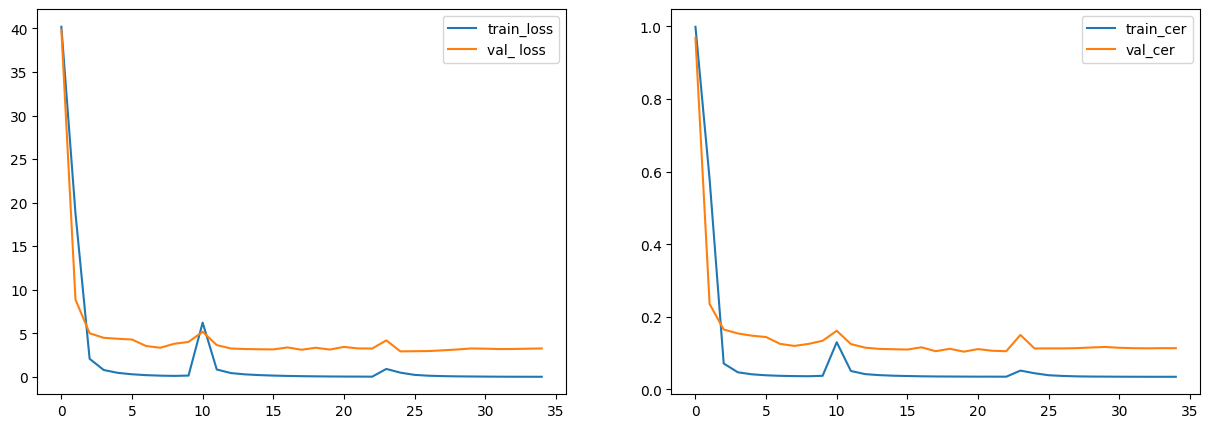

In [7]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(ncols=2, figsize=(15, 5))

axes[0].plot(history['train_loss'], label='train_loss')
axes[0].plot(history['val_loss'], label='val_ loss')

axes[1].plot(history['train_cer'], label='train_cer')
axes[1].plot(history['val_cer'], label='val_cer')

axes[0].legend()
axes[1].legend()

In [8]:
from utils.torch_helpers import validate_model

print(dict(zip(['batch_time', 'loss', 'metric'], [round(e, 6) for e in validate_model(model, val_loader, alphabet, device=device)])))

26it [00:01, 15.42it/s]

{'batch_time': 0.003886, 'loss': 14.043222, 'metric': 0.049891}


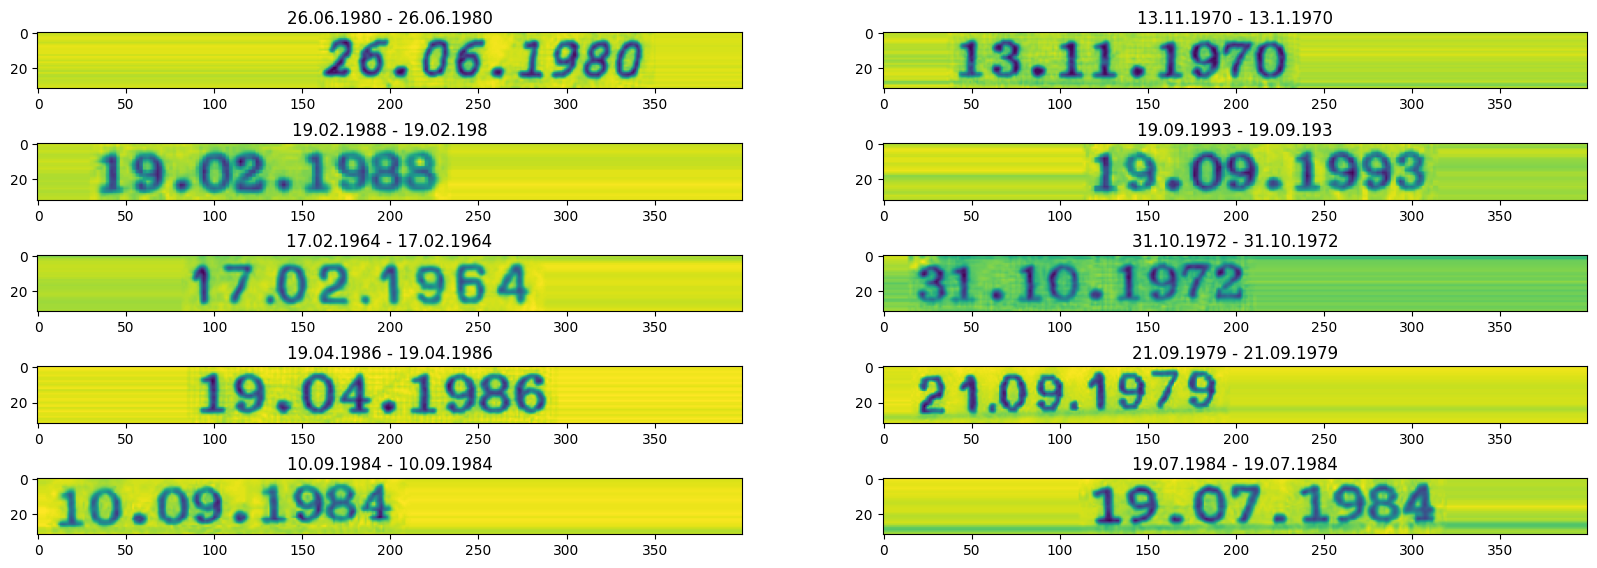

In [9]:
from itertools import groupby

fig, axes = plt.subplots(ncols=2, nrows=5, figsize=(20, 7))

model.eval()
(x1, x2), y = next(iter(val_loader))
y_pred = model(x1.to(device), x2.to(device))

decoded_pred = decode_texts(y_pred.detach().cpu().numpy(), alphabet, blank_idx=0)

for i in range(10):
    axes[i // 2, i % 2].imshow(x1[i, 0].detach().cpu().numpy())
    axes[i // 2, i % 2].set_title(f'{decoded_pred[i]} - {"".join(alphabet[k-1] for k, _ in groupby(y[i].cpu().numpy().astype(int)) if k != 0)}')

In [10]:
torch.save(best_state, '/content/drive/MyDrive/dnn_model_optimization/weights/crnn_common_fields.pt')

In [11]:
from google.colab import runtime

runtime.unassign()